In [39]:
import pandas as pd
from scipy import integrate
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display


neutron_pvs = ['RAD:Berthold:TotalNeutronRate', 'RAD:ELSE:Neutron', 'RAD:Thermo1:Neutron',\
    'RAD:Thermo2:Neutron', 'RAD:Thermo3:Neutron', 'RAD:Thermo4:Neutron', 'RAD:Thermo5:Neutron',\
        'RAD:Thermo6:Neutron', 'RAD:Thermo7:Neutron', 'RAD:Thermo8:Neutron', 'RAD:Thermo9:Neutron']


# Período com feixe
dt = 1 # days
FROM_NOW = False
if FROM_NOW:
    final_date_b = datetime.now().strftime("%Y-%m-%d")
    initial_date_b = (datetime.now() - timedelta(days=dt)).strftime("%Y-%m-%d")
    final_time_b = datetime.now().strftime('%H:%M:%S')
    initial_time_b = (datetime.now() - timedelta(days=dt)).strftime('%H:%M:%S')

else:
    initial_date_b = '2022-03-22'
    initial_time_b = '12:00:00'
    final_date_b = '2022-03-23'
    final_time_b = '12:00:00'

# Período sem feixe
initial_date_nb = '2022-03-09'
initial_time_nb = '12:00:00'
final_date_nb = '2022-03-10'
final_time_nb = '12:00:00'

def get_data(pvs: list, i_date: str, f_date: str, i_time: str, f_time: str):
    dfs = {}
    url_prefix = 'http://10.0.38.42/retrieval/data/getData.csv?pv='
    url_posfix = '&from={}T{}.000Z&to={}T{}.000Z'.format(i_date,\
        i_time.replace(':', '%3A'), f_date, f_time.replace(':', '%3A'))
    for _ in pvs:
        temp = pd.read_csv('{}{}{}'.format(url_prefix, _, url_posfix),\
            header = None, names = ["secs", "Dose Rate (uSv/h)", "severity", "status", "nanos"])
        temp['date'] = time = pd.to_datetime(temp['secs'], unit='s')
        temp['time (h)'] = (temp['secs'].subtract(temp['secs'][0]))/3600
        temp.drop('nanos', inplace=True, axis=1)
        temp.drop('severity', inplace=True, axis=1)
        temp.drop('status', inplace=True, axis=1)
        temp.drop('secs', inplace=True, axis=1)
        dfs[_] = temp
    return(dfs)

neutron_bgc = get_data(neutron_pvs, initial_date_nb, final_date_nb, initial_time_nb, final_time_nb)
neutron_b = get_data(neutron_pvs, initial_date_b, final_date_b, initial_time_b, final_time_b)

In [36]:
# Dose total menos BG (para 24 horas)
dose_b = []
dose_bgc = []
dose_nbg = []
for _ in neutron_pvs:
    dose_b.append(integrate.trapz(neutron_b[_]['Dose Rate (uSv/h)'].values, neutron_b[_]['time (h)'].values))
    dose_bgc.append(integrate.trapz(neutron_bgc[_]['Dose Rate (uSv/h)'].values, neutron_bgc[_]['time (h)'].values))
print(dose_bgc)
for _ in range(len(dose_b)):
    dose_nbg.append(dose_b[_] - dose_bgc[_])
dic = {'PV': neutron_pvs, 'Dose sem BG (uSv)': dose_nbg}
df = pd.DataFrame(dic, index=None)
display(df)

[0.27575250568047227, 0.15004888888888893, 0.3407504050236109, 0.18907925812777784, 0.16919261006666658, 0.19680532583611116, 0.18409484561666664, 0.17723482513611116, 0.19960159427361127, 0.2273463841569445, 0.16688490588333335]


,PV,Dose sem BG (uSv)
0,RAD:Berthold:TotalNeutronRate,0.036682
1,RAD:ELSE:Neutron,0.028637
2,RAD:Thermo1:Neutron,0.008373
3,RAD:Thermo2:Neutron,0.043970
4,RAD:Thermo3:Neutron,0.038303
5,RAD:Thermo4:Neutron,-0.002084
6,RAD:Thermo5:Neutron,-0.010603
7,RAD:Thermo6:Neutron,0.038024
8,RAD:Thermo7:Neutron,0.036575
9,RAD:Thermo8:Neutron,-0.008637


C:\Users\rafael.cardoso\AppData\Local\Temp\ipykernel_13868\2665801938.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<BarContainer object of 11 artists>

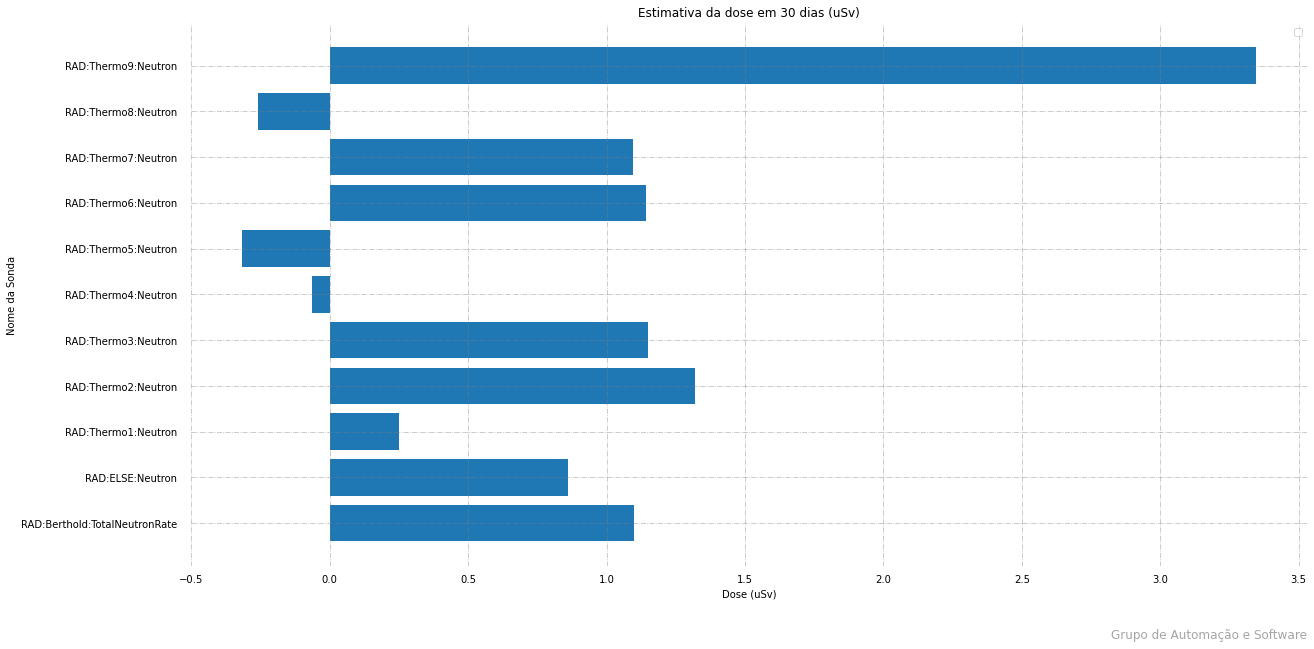

In [37]:
# Plota estimativa doses 30 dias

dose_nbg_30d = [x*30 for x in dose_nbg]
dic_30d = dic = {'PV': neutron_pvs, 'Dose sem BG (uSv)': dose_nbg_30d}

df = pd.DataFrame(dic_30d)
#display(df)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.8,
        alpha = 0.5)
# Add Text watermark
fig.text(0.9, 0.02, 'Grupo de Automação e Software', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
ax.set_title('{}'.format('Estimativa da dose em 30 dias (uSv)'))
ax.set_xlabel('Dose (uSv)')
ax.set_ylabel('Nome da Sonda')
ax.legend(loc='best')
ax.barh(df['PV'], df['Dose sem BG (uSv)'])

In [ ]:
# Média da taxa de dose de BG
neutron_bg_mean = []
for _ in neutron_bgc:
    neutron_bg_mean.append(np.mean(neutron_bgc[_]['Dose Rate (uSv/h)']))

# Média da taxa de dose com feixe menos o BG
neutron_b_mean = []
for _ in neutron_b:
    neutron_b_mean.append(np.mean(neutron_b[_]['Dose Rate (uSv/h)']))
for _ in range(len(neutron_b)):
    print(neutron_b_mean[_] - neutron_bg_mean[_])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


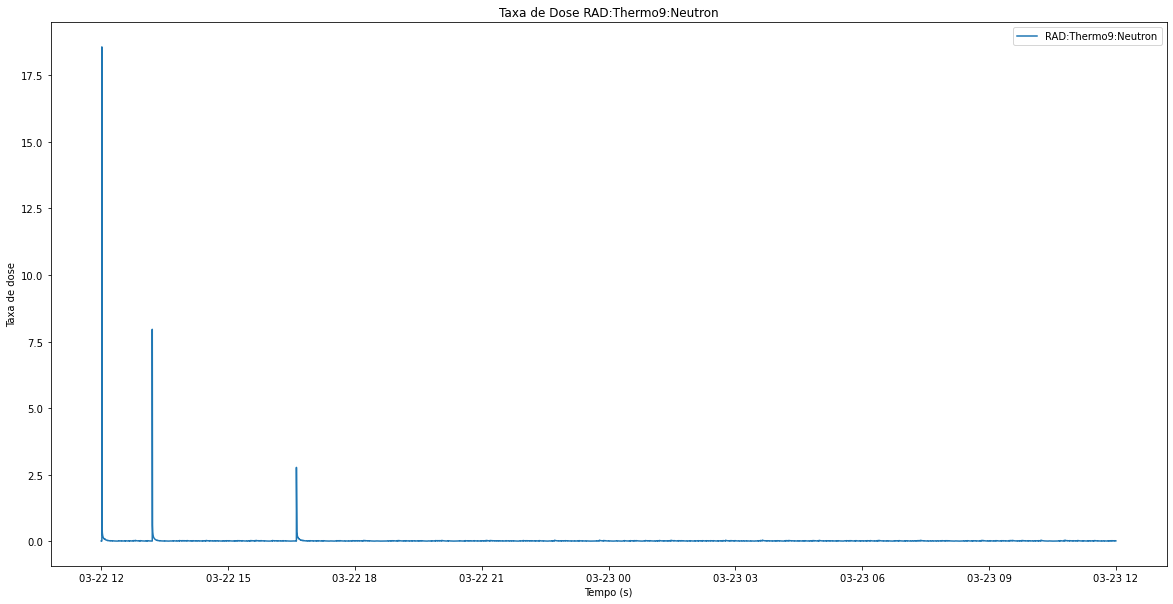

In [23]:
fig = plt.figure(figsize=(20,10))
axis = fig.add_subplot(111)
axis.set_title('Taxa de Dose {}'.format('RAD:Thermo9:Neutron'))
axis.set_xlabel('Tempo (s)')
axis.set_ylabel('Taxa de dose')
axis.legend(loc='best')
axis.plot(neutron_b['RAD:Thermo9:Neutron']['date'],\
    neutron_b['RAD:Thermo9:Neutron']['Dose Rate (uSv/h)'], label = 'RAD:Thermo9:Neutron')
axis.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


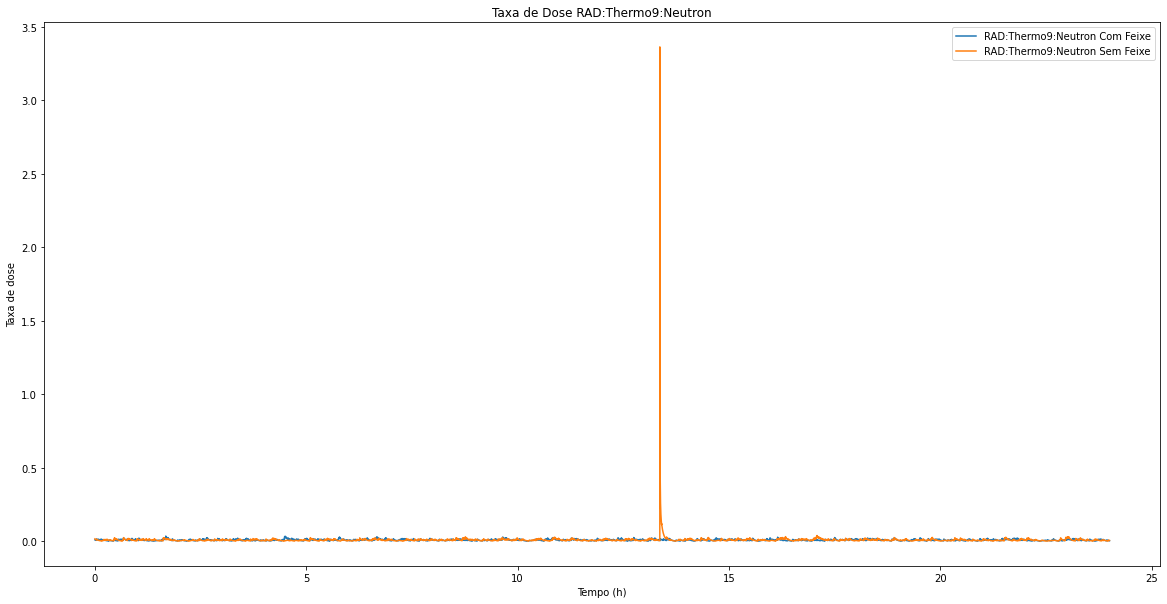

In [19]:
fig = plt.figure(figsize=(20,10))
axis = fig.add_subplot(111)
axis.set_title('Taxa de Dose {}'.format('RAD:Thermo9:Neutron'))
axis.set_xlabel('Tempo (h)')
axis.set_ylabel('Taxa de dose')
axis.legend(loc='best')
axis.plot(neutron_b['RAD:Thermo9:Neutron']['time (h)'],\
    neutron_b['RAD:Thermo9:Neutron']['Dose Rate (uSv/h)'], label = 'RAD:Thermo9:Neutron Com Feixe')
axis.plot(neutron_bgc['RAD:Thermo9:Neutron']['time (h)'],\
    neutron_bgc['RAD:Thermo9:Neutron']['Dose Rate (uSv/h)'], label = 'RAD:Thermo9:Neutron Sem Feixe')
axis.legend()